In [1]:
# import modules
import os
import datetime as dt
from collections import Counter
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import raw_data_process

# Load CSV Raw Data

In [ ]:
# dir and file path
RAW_FLOW_DIRECTORY = 'raw_data/flow'
PARQUET_FLOW_DIRECTORY = 'data/flow'
RAW_STATION_DIRECTORY = 'raw_data/station_meta'
PARQUET_STATION_DIRECTORY = 'data/station_meta'
RAW_PM_DIRECTORY = 'raw_data/pm'
PARQUET_PM_DIRECTORY = 'data/pm'

In [ ]:
# read raw csv data and save them as parquet
flow_dict = raw_data_process.raw_flow_to_parquet(RAW_FLOW_DIRECTORY, PARQUET_FLOW_DIRECTORY)
sdf = raw_data_process.tweak_station_meta(RAW_STATION_DIRECTORY, 2019, flow_dict['d12_20191008'], PARQUET_STATION_DIRECTORY)
pmdf = raw_data_process.tweak_pm_df(RAW_PM_DIRECTORY, PARQUET_PM_DIRECTORY)

# Load Parquet Data

- `raw_flow_dict`
- `sdf`
- `pmdf`

In [2]:
raw_flow_dict, sdf, pmdf = raw_data_process.load_parquet_data('data')

## View Imported Data

In [ ]:
raw_flow_dict

In [ ]:
sdf.head(3)

In [ ]:
pmdf.head(3)

# Select Desired Route, Direction, and Lane Type

- Sort by `timestamp` and `station`

### Route 405-N-ML as Test Case

- Check shape
- Check if each station is unique


In [3]:
# TODO: loop through all the df in flow dictionary 
flow_405N_ML = raw_data_process.select_route(raw_flow_dict['d12_20191008'], 405, 'N', 'ML')

In [4]:
flow_405N_ML.head(10)

,timestamp,station,district,freeway_num,direction,lane_type,station_length,samples,pct_observed,total_flow,avg_occupancy,avg_speed
0,2019-10-08 00:00:00-07:00,1201100,12,405,N,ML,0.255,50,100,37.0,0.0045,72.6
1,2019-10-08 00:00:00-07:00,1209162,12,405,N,ML,0.390,31,67,20.0,0.0049,61.5
2,2019-10-08 00:00:00-07:00,1209176,12,405,N,ML,0.480,50,100,63.0,0.0078,71.5
3,2019-10-08 00:00:00-07:00,1209204,12,405,N,ML,0.335,59,83,212.0,0.0810,56.8
4,2019-10-08 00:00:00-07:00,1209243,12,405,N,ML,0.556,0,0,212.0,0.0263,67.4
5,2019-10-08 00:00:00-07:00,1211066,12,405,N,ML,0.535,13,100,14.0,0.0024,67.7
6,2019-10-08 00:00:00-07:00,1213650,12,405,N,ML,0.380,60,100,170.0,0.0148,69.6
7,2019-10-08 00:00:00-07:00,1213963,12,405,N,ML,0.345,40,50,60.0,0.0152,67.3
8,2019-10-08 00:00:00-07:00,1214080,12,405,N,ML,0.225,0,0,154.0,0.0381,66.3
9,2019-10-08 00:00:00-07:00,1214212,12,405,N,ML,0.400,40,100,62.0,0.0111,68.9


# Process Flow 

In [6]:
flow_405N_ML = raw_data_process.process_flow_merge_sdf(flow_405N_ML, sdf)

In [7]:
flow_405N_ML.head(10)

,station,0000,0005,0010,0015,0020,0025,0030,0035,0040,...,2315,2320,2325,2330,2335,2340,2345,2350,2355,abs_pm
0,1211066,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,NaN,NaN,17.0,0.0,0.0,0.0,NaN,0.0,0.0,0.37
1,1201100,37.0,43.0,45.0,56.0,42.0,37.0,41.0,32.0,48.0,...,75.0,66.0,55.0,56.0,67.0,73.0,72.0,51.0,37.0,0.70
2,1209176,63.0,58.0,66.0,62.0,65.0,66.0,48.0,53.0,56.0,...,115.0,89.0,94.0,79.0,88.0,100.0,96.0,82.0,61.0,2.12
3,1201159,43.0,41.0,44.0,51.0,46.0,46.0,32.0,37.0,42.0,...,84.0,74.0,64.0,57.0,65.0,71.0,66.0,65.0,41.0,2.81
4,1209059,79.0,64.0,75.0,69.0,68.0,74.0,47.0,55.0,64.0,...,123.0,115.0,96.0,93.0,97.0,113.0,96.0,93.0,64.0,3.08
5,1201185,79.0,59.0,67.0,66.0,71.0,66.0,46.0,57.0,51.0,...,116.0,106.0,87.0,92.0,89.0,100.0,100.0,87.0,58.0,3.63
6,1201211,77.0,62.0,65.0,69.0,76.0,64.0,46.0,57.0,54.0,...,119.0,106.0,86.0,93.0,90.0,100.0,99.0,58.0,39.0,3.80
7,1201222,60.0,58.0,0.0,40.0,62.0,18.0,42.0,42.0,0.0,...,132.0,128.0,97.0,94.0,98.0,110.0,114.0,94.0,68.0,4.78
8,1201254,155.0,136.0,141.0,153.0,146.0,148.0,135.0,126.0,114.0,...,209.0,195.0,187.0,153.0,154.0,150.0,173.0,166.0,130.0,5.32
9,1201283,83.0,64.0,71.0,70.0,73.0,66.0,64.0,59.0,52.0,...,138.0,129.0,109.0,101.0,106.0,104.0,111.0,108.0,64.0,5.51


In [8]:
route_mean_flow = raw_data_process.process_flow_interpolation(flow_405N_ML, pmdf, 12, 405)
route_mean_flow

,freeway_num,district,abs_pm,latitude,longitude,abs_pm_range,0000,0005,0010,0015,...,2310,2315,2320,2325,2330,2335,2340,2345,2350,2355
0,405,12,0.23,33.643991,-117.735577,"(0.0, 0.23]",14.0,0.0,0.0,0.0,...,97.0,75.0,66.0,17.0,0.0,0.0,0.0,72.0,0.0,0.0
1,405,12,0.30,33.644606,-117.736518,"(0.23, 0.3]",14.0,0.0,0.0,0.0,...,97.0,75.0,66.0,17.0,0.0,0.0,0.0,72.0,0.0,0.0
2,405,12,0.40,33.645283,-117.738040,"(0.3, 0.4]",14.0,0.0,0.0,0.0,...,97.0,75.0,66.0,17.0,0.0,0.0,0.0,72.0,0.0,0.0
3,405,12,0.50,33.645762,-117.739672,"(0.4, 0.5]",37.0,43.0,45.0,56.0,...,97.0,75.0,66.0,55.0,56.0,67.0,73.0,72.0,51.0,37.0
4,405,12,0.60,33.646240,-117.741304,"(0.5, 0.6]",37.0,43.0,45.0,56.0,...,97.0,75.0,66.0,55.0,56.0,67.0,73.0,72.0,51.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,405,12,23.80,33.780904,-118.090590,"(23.7, 23.8]",65.0,70.0,76.0,68.0,...,137.0,125.0,138.0,97.0,109.0,87.0,98.0,88.0,94.0,94.0
237,405,12,23.90,33.782308,-118.090975,"(23.8, 23.9]",65.0,70.0,76.0,68.0,...,137.0,125.0,138.0,97.0,109.0,87.0,98.0,88.0,94.0,94.0
238,405,12,24.00,33.783682,-118.091464,"(23.9, 24.0]",65.0,70.0,76.0,68.0,...,137.0,125.0,138.0,97.0,109.0,87.0,98.0,88.0,94.0,94.0
239,405,12,24.10,33.785060,-118.092377,"(24.0, 24.1]",65.0,70.0,76.0,68.0,...,137.0,125.0,138.0,97.0,109.0,87.0,98.0,88.0,94.0,94.0


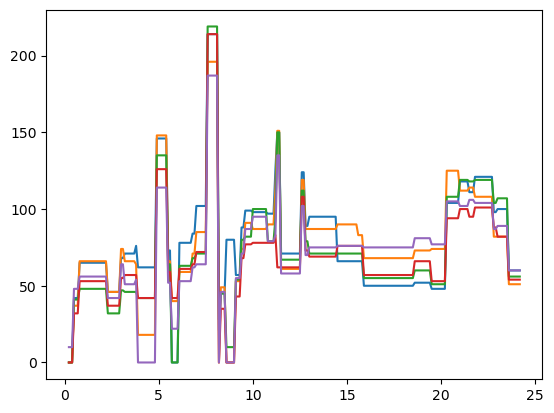

In [18]:
plt.plot(route_mean_flow['abs_pm'], route_mean_flow.iloc[:, 10:15])

## Assign Null values to traffic flow

- Assigns NaN to the 'total_flow' column where the 'pct_observed' is less than 70

### Check NaN Values

- Pivot the raw df with index=station, columns=timestamp, values=total_flow
- Drop the row if the row includes more than 50% of NaN

### Naming

- {route_type}\_{route_num}{direction}\_{lane_type}

## Merge, fillna, Interpolation

Merge ready dfs:
- Flow: I_405N_ML_merged
- Postmile: I_405N_pm

In [ ]:
def flow_interpolation(route_merged_df, route_pm_df):
    """
    This function combines route_merged_df and route_pm_df and calculate the flow at each pm
    It first creates bins (pm_range) based on route_pm_df and route_merged_df
    Then it calculates the mean of flow for each bin
    It fills out the nan values by backfill method across row (axis=0), then interpolate flow across columns (axis=1)
    For the last few nan rows beyond pm range from flow data, it forward fills nan
    :param route_merged_df:
    :param route_pm_df:
    :return: a
    """
    # make copies of input dfs
    route_df = route_merged_df.copy()
    pm_df = route_pm_df.copy()

    # create a list of bins that will be used for PM range later
    bins = [0] + pm_df['abs_pm'].tolist() + [np.inf]

    # append the bins to route_merged_df
    route_df['abs_pm_range'] = pd.cut(route_df['abs_pm'], bins=bins)

    # calculate mean flow
    route_mean_flow = route_df.iloc[:, 1:].groupby('abs_pm_range').mean().reset_index().iloc[:, 0:-2]

    # delete the last row (last_pm, np.inf]
    route_mean_flow = route_mean_flow.drop(route_mean_flow.index[-1])

    # check if rows of route_mean_flow and pm_df are the same
    if len(route_mean_flow) == len(pm_df):
        route_mean_flow_pm = pm_df.merge(route_mean_flow, left_index=True, right_index=True)

        # forward fillna for pm within route_flow_range, back fillna beyound route_flow_range
        route_mean_flow_pm = route_mean_flow_pm.fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)

        # interpolate nan across columns (across time)
        route_mean_flow_pm.iloc[:, 6:-1] = route_mean_flow_pm.iloc[:, 6:-1].interpolate(axis=1).round(0)
        return route_mean_flow_pm
    else:
        return 'Error, check input dfs'

In [ ]:
I_405N_mean_flow_pm = flow_interpolation(I_405N_ML_merged, I_405N_pm)

In [ ]:
# check no nan values in the flow data
np.sum(I_405N_mean_flow_pm.isnull().sum())

In [ ]:
I_405N_mean_flow_pm.head(1)

In [ ]:
I_405_total_flow_test = I_405N_mean_flow_pm.iloc[:, 6:-1].mean()

In [ ]:
I_405_total_flow_test

In [ ]:
plt.plot(I_405_total_flow_test)

In [ ]:
def plot_station_flow(interpolated_df, uninterpolated_df, num_intervals):
     if num_intervals not in [3, 6, 9, 12]:
          raise ValueError("'num_intervals' must be either 3, 6, 9, or 12.")

     # TODO: only slice the first row

     fig, ax = plt.subplots(figsize=(20, 6))

     # plot interpolated flow
     time_of_day = interpolated_df.columns[1:-3]
     interpolated_flow = interpolated_df.iloc[0, 1:-3]
     ax.plot(time_of_day, interpolated_flow)

     # plot uninterpolated flow
     uninterpolated_flow = uninterpolated_df.iloc[0, 1:-3]
     missing_flow = uninterpolated_flow[pd.isna(uninterpolated_flow)]
     missing_flow_x = missing_flow.index
     missing_flow_y = [interpolated_flow[time] for time in missing_flow_x]
     ax.plot(missing_flow_x, missing_flow_y, 'ro', label='Interpolated Flow')

     # only show every 15 minutes
     xtick_position = range(0, len(time_of_day), num_intervals)
     xtick_labels = time_of_day[::num_intervals]

     # set ax xticks
     ax.set_xticks(xtick_position)
     ax.set_xticklabels(xtick_labels, rotation=90)

     # set x-axis labels
     ax.set_xlabel('Time')

     # set y-axis labels
     ax.set_ylabel('Total Flow')

     # add a legend
     ax.legend()

     # show the plot
     plt.show()



In [ ]:
plot_station_flow(df_405N_ML_interpolated, df_405N_ML_merged, 12)

In [ ]:
df_a = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5]})
df_c = pd.DataFrame({'PM': [0.03, 0.26, 0.35, 0.4, 0.49, 0.65], 'traffic_flow': [100, 200, 300, 400, np.nan, 600]})

# Create a boolean column indicating if the value was interpolated
df_c['interpolated'] = df_c['traffic_flow'].isna()

# Interpolate missing traffic_flow values in df_c
df_c['traffic_flow'] = df_c['traffic_flow'].interpolate()

# Create interval bins
bins = df_a['PM'].tolist() + [np.inf]

# Assign each PM in df_c to an interval in df_a
df_c['PM_range'] = pd.cut(df_c['PM'], bins=bins)

# Group by PM_range and calculate mean traffic_flow and maximum interpolated
traffic_flow_mean = df_c.groupby('PM_range').agg({'traffic_flow': 'mean', 'interpolated': 'max'}).reset_index()

traffic_flow_mean['PM'] = traffic_flow_mean['PM_range'].apply(lambda x: x.left)

# Merge the average traffic_flow and interpolated to df_a
df_final = pd.merge(df_a, traffic_flow_mean, on='PM', how='left')

# Clean up the final dataframe
df_final = df_final.drop(columns='PM_range')
df_final


In [ ]:
import matplotlib.pyplot as plt

df_d = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                     'traffic_flow': [100, 150, 200, 350, 500, 600],
                     'interpolated': [False, True, False, False, True, False]})

plt.figure(figsize=(5, 4))
# Plot all points with a line
plt.plot(df_d['PM'], df_d['traffic_flow'], color='blue')

# Overplot the interpolated points with red color
plt.scatter(df_d[df_d['interpolated']]['PM'],
            df_d[df_d['interpolated']]['traffic_flow'],
            color='red')

plt.xlabel('PM')
plt.ylabel('traffic_flow')
plt.title('Traffic flow vs PM')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

df_d = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                     'traffic_flow': [100, 150, 200, 350, 500, 600],
                     'interpolated': [False, True, False, False, True, False]})

plt.figure(figsize=(5, 3))

# Loop over each segment
for i in range(len(df_d['PM']) - 1):
    x = df_d['PM'].iloc[i:i+2]
    y = df_d['traffic_flow'].iloc[i:i+2]

    # If the current point is interpolated, the line to the next point is red, else blue
    color = 'red' if df_d['interpolated'].iloc[i] else 'blue'
    plt.plot(x, y, color=color)

plt.xlabel('PM')
plt.ylabel('traffic_flow')
plt.title('Traffic flow vs PM')
plt.show()